In [1]:
from google.protobuf.json_format import MessageToDict
import requests
import matplotlib.pyplot as plt
import numpy as np
import tomtomtrafficflowTile_pb2
import math
import pandas as pd
import schedule
import time
from datetime import datetime, timedelta
import os
import locale
import keyboard

In [2]:
# Valores globales
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')
apiKey = "0dR1w4GQ3fKtlRIKGrdiLNmJCQgAZiIC"     
zoom_level = 16
tile = tomtomtrafficflowTile_pb2.Tile()
tiles_largo = 3
tiles_ancho = 3

In [3]:
def tileZXYToLatLon(z, x, y):
    MAX_ZOOM_LEVEL = 22

    if z > MAX_ZOOM_LEVEL or (z is None or not isinstance(z, (int, float))):
        raise ValueError(f"Zoom level value is out of range [0, {MAX_ZOOM_LEVEL}]")
    minXY = 0
    maxXY = int(2**z - 1)
    if x > maxXY or x < minXY or x is None or not isinstance(x, (int, float)):
        raise ValueError(f"Tile x value is out of range [0, {maxXY}]")

    if y > maxXY or y < minXY or y is None or not isinstance(y, (int, float)):
        raise ValueError(f"Tile y value is out of range [0, {maxXY}]")

    
    lon = (x / (2**z)) * (360.0) - (180.0)
    n = (math.pi) - (2.0 * math.pi * y) / (2**z)
    lat = (180.0 / math.pi) * (math.atan(0.5 * (math.exp(n) - math.exp(-n))))
   
    return lat,lon

In [4]:
# Función para convertir coordenadas geodésicas a coordenadas de tiles
def lat_lon_to_tile_zxy(lat, lon, zoom_level):
    
    min_zoom_level = 0
    max_zoom_level = 22
    min_lat = -85.051128779807
    max_lat = 85.051128779806
    min_lon = -180.0
    max_lon = 180.0

    # Check input values of zoom level, latitude and longitude
    if (zoom_level is None or not isinstance(zoom_level, (int, float))
        or zoom_level < min_zoom_level
        or zoom_level > max_zoom_level ):
        
        raise ValueError(
            f"Zoom level value is out of range [{min_zoom_level}, {max_zoom_level}]"
        )

    if lat is None or not isinstance(lat, (int, float)) or lat < min_lat or lat > max_lat:
        raise ValueError(f"Latitude value is out of range [{min_lat}, {max_lat}]")

    if (lon is None or not isinstance(lon, (int, float))
        or lon < min_lon
        or lon > max_lon ):
        
        raise ValueError(f"Longitude value is out of range [{min_lon}, {max_lon}]")

    z = int(zoom_level)
    xy_tiles_count = 2**z
    x = int(((lon + 180.0) / 360.0) * xy_tiles_count)
    y = int(((1.0 - math.log( math.tan((lat * math.pi) / 180.0) + 1.0 / math.cos((lat * math.pi) / 180.0)) /math.pi)/ 2.0)* xy_tiles_count)

    return x,y

In [5]:
def transform(decodedTiles, zoom_level, xTile, yTile):
    lat_inicio, lon_inicio = tileZXYToLatLon(zoom_level, xTile, yTile)
    
    #lat_fin, lon_fin = tileZXYToLatLon(zoom_level, xTile+tiles_ancho, yTile+tiles_largo)
    lat_fin, lon_fin = tileZXYToLatLon(zoom_level, xTile+1, yTile+1)
    #lat_inicio=19.49766417 #116592 cambio en y
    #lon_inicio=-99.17770386 #58853 cambio en x
    #lat_fin=19.49636962  #116593
    #lon_fin=-99.17633057 #58854

    # Calcular diferencias en latitud y longitud
    diff_lat =lat_fin-lat_inicio
    diff_lon =lon_fin-lon_inicio

    num_pixeles = 4096
    coordinates = []

    # Calcular incrementos por píxel
    inc_lat = diff_lat / num_pixeles
    inc_lon = diff_lon / num_pixeles
    for x,y in decodedTiles:
        lat_pixel = lat_inicio + (y * inc_lat)
        lon_pixel = lon_inicio + (x * inc_lon)
        coordinates.append((lat_pixel, lon_pixel))
    return coordinates

In [6]:
def decode_geometry(geometry):
    c = 0
    decodeTiles = []
    decode_x = 0
    decode_y = 0
    while c < len(geometry):
        command_and_count = geometry[c]
        command = command_and_count & 0x7
        count = command_and_count >> 0x3
        for _ in range(count):
            x = geometry[c+1] 
            y = geometry[c+2]
            decode_x += ((x >> 0x1) ^ (-(x & 0x1))) 
            decode_y += ((y >> 0x1) ^ (-(y & 0x1)))
            decodeTiles.append([decode_x, decode_y])            
            c += 2
        c += 1        
    return  decodeTiles

In [9]:
"""
archivo_excel = 'C:/Users/valer/Documents/CIC/doctorado/air_pollution/traffic_flow/vector/estaciones.xlsx'
df = pd.read_excel(archivo_excel)
for i in range(len(df)):
    #print(i)
    estacion = df.loc[i]
    latitud = estacion.Latitude
    longitud = estacion.Longitude
    if pd.notna(latitud):
        tileX, tileY = lat_lon_to_tile_zxy(latitud, longitud, zoom_level)
        df.at[i,"xTile_in"] = tileX
        df.at[i,"yTile_in"] = tileY
df.to_excel(archivo_excel, index=False)  # index=False evita escribir el índice en el archivo
"""

In [11]:
archivo_excel = 'C:/Users/valer/Documents/CIC/doctorado/air_pollution/traffic_flow/vector/estaciones.xlsx'
# Leer el archivo Excel en un DataFrame de pandas
df = pd.read_excel(archivo_excel)
#Ignora las filas con datos faltantes en la columna de Latitude (i.e. solo toma en cuenta las estaciones de las que se conoce su ubicación)
estaciones = df.dropna(subset=['Latitude'])
estaciones

,Clave,Nombre,Alcaldía o municipio,No. ID,Latitude,Longitude,xTile_in,yTile_in,Altitud (msnm),Estatus
0,ACO,Acolman,Acolman,484150020109,19.635501,-98.912003,14761,29121,2198,Activa
1,AJU,Ajusco,Tlalpan,484090120400,19.154674,-99.162459,14716,29214,2953,Activa
2,AJM,Ajusco Medio,Tlalpan,484090120609,19.272100,-99.207658,14707,29191,2619,Activa
3,ATI,Atizapán,Atizapán de Zaragoza,484150130101,19.576963,-99.254133,14699,29132,2341,Activa
4,BJU,Benito Juarez,Benito Juárez,484090140309,19.371612,-99.158969,14716,29172,2250,Activa
5,CAM,Camarones,Azcapotzalco,484090020301,19.468404,-99.169794,14714,29153,2233,Activa
6,CCA,Centro de Ciencias de la Atmósfera,Coyoacán,484090030501,19.326200,-99.176100,14713,29181,2280,Activa
7,TEC,Cerro del Tepeyac,Gustavo A. Madero,484090050404,19.487227,-99.114229,14724,29150,2265,Activa
8,CHO,Chalco,Chalco,484150250109,19.266948,-98.886088,14766,29192,2253,Activa
9,COR,CORENA,Xochimilco,484090130204,19.265346,-99.026040,14740,29192,2242,Activa


In [9]:
dir_save_vectores = "vectores"
tile = tomtomtrafficflowTile_pb2.Tile()
zoom_level = 16
tecla_activacion="a"
def descargar_datos():
    for i in range(len(estaciones)):
        estacion = estaciones.iloc[i]
        nombre = estacion.Clave
        tileX = estacion.xTile_in
        tileY = estacion.yTile_in
        if pd.notna(tileX):
            x_tile_in = tileX -1
            x_tile_end = x_tile_in + 3
            y_tile_in = tileY -1
            y_tile_end = y_tile_in + 3
            datetime_now = datetime.now()
            datetime_string = f"{datetime_now.year}_{datetime_now.month:02d}_{datetime_now.day:02d}_{datetime_now.hour:02d}_{datetime_now.minute:02d}_{datetime_now.second:02d}"
            mes = datetime_now.strftime("%B")
            ruta_carpeta = os.path.join(dir_save_vectores, mes)
            if not os.path.exists(ruta_carpeta):
                os.makedirs(ruta_carpeta)
            dia = datetime_now.date()
            ruta_carpeta = os.path.join(ruta_carpeta, str(dia))
            if not os.path.exists(ruta_carpeta):
                os.makedirs(ruta_carpeta)
            hora = str(datetime_now.hour)
            ruta_carpeta = os.path.join(ruta_carpeta, hora)
            if not os.path.exists(ruta_carpeta):
                os.makedirs(ruta_carpeta)
            minuto = str(datetime_now.minute)
            #print(minuto)
            ruta_carpeta = os.path.join(ruta_carpeta, minuto)
            if not os.path.exists(ruta_carpeta):
                os.makedirs(ruta_carpeta)

            x_tile = int(x_tile_in)
            y_tile = int(y_tile_in)
            tiles_largo = 3
            tiles_ancho = 3
            #print(x_tile, y_tile)
            for j in range(tiles_largo):
                x_tile = int(x_tile_in)
                #print("j=",j)
                for k in range(tiles_ancho):
                    otro_intento = True
                    #while(otro_intento==True):
                    for intentos in range(3):
                        if otro_intento ==True:
                            #print("k=",k)
                            url = 'https://api.tomtom.com/traffic/map/4/tile/flow/relative/'+str(zoom_level)+'/'+str(x_tile)+'/'+str(y_tile)+'.pbf?margin=0&tags=%5Btraffic_level%2Ctraffic_road_coverage%2Cleft_hand_traffic%2Croad_closure%2Croad_category%2Croad_subcategory%5D&key='+ apiKey
                            #print(url)
                            response = requests.get(url)
                            if response.status_code == 200:
                                nombre_archivo = nombre+"_"+str(int((j*tiles_ancho)+k))+"_"+str(zoom_level)+"_"+str(x_tile) + "_"+ str(y_tile)+"_"+datetime_string+'.pbf'
                                ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
                                with open(ruta_archivo, 'wb') as archivo:
                                        archivo.write(response.content)
                                with open(ruta_archivo, "rb") as f:
                                    tile.ParseFromString(f.read())
                                dict_request = MessageToDict(tile)
                                #print(dict_request)
                                if dict_request['layers'][0]['name'] == 'Traffic flow':
                                    print(f'Archivo guardado como: {ruta_archivo}') 
                                    otro_intento = False
                                else:
                                    os.remove(ruta_archivo)
                                    otro_intento = True
                                    time.sleep(10)   
                            else:
                                print(f'Error al realizar la solicitud. Código de estado: {response.status_code}')
                    x_tile = int(x_tile +1)
                y_tile = int(y_tile +1)
    return
#descargar_datos()

In [10]:
"""
hora_actual = datetime.now()
hora_inicio = hora_actual.replace(hour=15, minute=10, second=0, microsecond=0)
schedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)
hora_actual = datetime.now()
hora_inicio = hora_actual.replace(hour=15, minute=15, second=0, microsecond=0)
schedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)
hora_actual = datetime.now()
hora_inicio = hora_actual.replace(hour=15, minute=20, second=0, microsecond=0)
schedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)
"""

'\nhora_actual = datetime.now()\nhora_inicio = hora_actual.replace(hour=15, minute=10, second=0, microsecond=0)\nschedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)\nhora_actual = datetime.now()\nhora_inicio = hora_actual.replace(hour=15, minute=15, second=0, microsecond=0)\nschedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)\nhora_actual = datetime.now()\nhora_inicio = hora_actual.replace(hour=15, minute=20, second=0, microsecond=0)\nschedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)\n'

In [11]:
while True:
    hora_actual = datetime.now()
    hora = str(hora_actual.hour)
    minuto = str(hora_actual.minute)
    #if keyboard.is_pressed(tecla_activacion):
    print(hora, minuto)
    #    keyboard.wait(tecla_activacion, suppress=True)
    if minuto == "0":
        try:
            descargar_datos()
        except:
            print("No se descargaron datos a las: ", hora,":", minuto)
    if minuto == "15":
        try:
            descargar_datos()
        except:
            print("No se descargaron datos a las: ", hora,":", minuto)
    if minuto == "30":
        try:
            descargar_datos()
        except:
            print("No se descargaron datos a las: ", hora,":", minuto)
    if minuto == "45":
        try:
            descargar_datos()
        except:
            print("No se descargaron datos a las: ", hora,":", minuto)

    time.sleep(60)


17 28
17 29
17 30
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_0_16_14706_29190_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_1_16_14707_29190_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_2_16_14708_29190_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_3_16_14706_29191_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_4_16_14707_29191_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_5_16_14708_29191_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_6_16_14706_29192_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_7_16_14707_29192_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJU_8_16_14708_29192_2024_03_22_17_30_52.pbf
Archivo guardado como: vectores\marzo\2024-03-22\17\30\AJM_0_16_14706_29190_2024_0

In [ ]:

"""
# Obtener la hora actual
hora_actual = datetime.now()

# Definir la hora específica para empezar (por ejemplo, 9:00 AM)
hora_inicio = hora_actual.replace(hour=14, minute=0, second=0, microsecond=0)

# Calcular el tiempo hasta la próxima hora específica
tiempo_hasta_inicio = hora_inicio - hora_actual
if tiempo_hasta_inicio.total_seconds() < 0:
    tiempo_hasta_inicio += timedelta(minutes=1)  # Si la hora ya pasó, ajustar para el próximo día

# Programar la ejecución cada 15 minutos después de la hora de inicio
schedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)
schedule.every(15).minutes.do(descargar_datos)

# Dormir hasta la hora de inicio
time.sleep(tiempo_hasta_inicio.total_seconds())

# Mantener el script en ejecución
while True:
    schedule.run_pending()
    time.sleep(1)
"""

'\n# Obtener la hora actual\nhora_actual = datetime.now()\n\n# Definir la hora específica para empezar (por ejemplo, 9:00 AM)\nhora_inicio = hora_actual.replace(hour=14, minute=0, second=0, microsecond=0)\n\n# Calcular el tiempo hasta la próxima hora específica\ntiempo_hasta_inicio = hora_inicio - hora_actual\nif tiempo_hasta_inicio.total_seconds() < 0:\n    tiempo_hasta_inicio += timedelta(minutes=1)  # Si la hora ya pasó, ajustar para el próximo día\n\n# Programar la ejecución cada 15 minutos después de la hora de inicio\nschedule.every().day.at(str(hora_inicio.time())).do(descargar_datos)\nschedule.every(15).minutes.do(descargar_datos)\n\n# Dormir hasta la hora de inicio\ntime.sleep(tiempo_hasta_inicio.total_seconds())\n\n# Mantener el script en ejecución\nwhile True:\n    schedule.run_pending()\n    time.sleep(1)\n'

In [11]:
# cantidad de estaciones a monitorear gratis con tomtom
50000/(9*4*24)
#metros por tile *numero de tiles alrededor de la estacion
#611.496*1.5

57.870370370370374

In [69]:
def conversion_vector(ruta_archivo, zoom_level, xTile, yTile, fecha, hora):
  #conversion vector a dataframe
  with open(ruta_archivo, "rb") as f:
    tile.ParseFromString(f.read())
  dict_request = MessageToDict(tile)
  points = []
  dictionary ={}
  if dict_request['layers'][0]['name'] == 'Traffic flow':
    keys = dict_request['layers'][0]["keys"]
    values = dict_request['layers'][0]["values"]
    for line in dict_request['layers'][0]["features"]:
        all_properties = []
        geometry = line["geometry"]
        decodedTiles = decode_geometry(geometry)
        coordinates = transform(decodedTiles, zoom_level, xTile, yTile)
        tags = line["tags"]
        for i in range(0, int(len(tags)/2), 2):
            key = keys[tags[i]]
            value = values[tags[i+1]]
            value = value[list(value.keys())[0]]
            properties = {key:value}
            all_properties.append(properties)
        if len(coordinates)>0:
            dictionary = {"type": line["type"],
                        "properties": all_properties,
                        "coordinates":coordinates,
                        "date":fecha,
                        "time":hora}
            points.append(dictionary)
    # Lista de nombres de columnas
    columnas = ['type', 'properties', 'coordinates']
    # Crear un DataFrame a partir de la lista y los nombres de columnas
    dataframe = pd.DataFrame(points, columns=columnas)
  return dataframe, points

In [65]:
fecha = nombre[7]+"-"+nombre[6]+"-"+nombre[5]
ultimo = nombre[10].split(".")
hora = nombre[8]+":"+nombre[9]+":"+ultimo[0]
hora

'15:31:22'

In [70]:
ruta_raiz = 'C:/Users/valer/Documents/CIC/doctorado/air_pollution/traffic_flow/vector/vectores/' 
dataframes = []
all_points = []
num_file = 0
# Itera sobre todas las carpetas y subcarpetas
for carpeta_actual, carpetas, archivos in os.walk(ruta_raiz):
    # Itera sobre todos los archivos en la carpeta actual
    for nombre_archivo in archivos:
        # Forma la ruta completa del archivo
        ruta_archivo = os.path.join(carpeta_actual, nombre_archivo)
        
        # Verifica si el archivo tiene una extensión específica (por ejemplo, .xlsx)
        if nombre_archivo.endswith('.pbf'):
            #print(num_file, nombre_archivo)
            # Lee el archivo y agrega el DataFrame a la lista
            nombre = nombre_archivo.split("_")
            zoom_level = int(nombre[2])
            xTile = int(nombre[3])
            yTile = int(nombre[4])
            fecha = nombre[7]+"-"+nombre[6]+"-"+nombre[5]
            ultimo = nombre[10].split(".")
            hora = nombre[8]+":"+nombre[9]+":"+ultimo[0]
            df, points = conversion_vector(ruta_archivo, zoom_level, xTile, yTile, fecha, hora)
            dataframes.append(df)
            all_points.append(points)
            num_file = num_file +1

# Combina todos los DataFrames en uno solo
df_completo = pd.concat(dataframes, ignore_index=True)

# Muestra el DataFrame completo
df_completo

,type,properties,coordinates
0,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.325524613420782, -99.20654296875), (19.32..."
1,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.32602544853046, -99.20379638671875), (19...."
2,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.32669491605546, -99.20331090688705), (19...."
3,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.325925154955115, -99.20242309570312), (19..."
4,LINESTRING,"[{'traffic_level': 0.9430000185966492}, {'traf...","[(19.325399009163966, -99.20421615242958), (19..."
...,...,...,...
51315,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.469468790805465, -99.0396036207676), (19...."
51316,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.46855208531823, -99.04120221734047), (19...."
51317,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.471771302105125, -99.03993487358093), (19..."
51318,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(19.468734161994316, -99.041748046875), (19.4..."


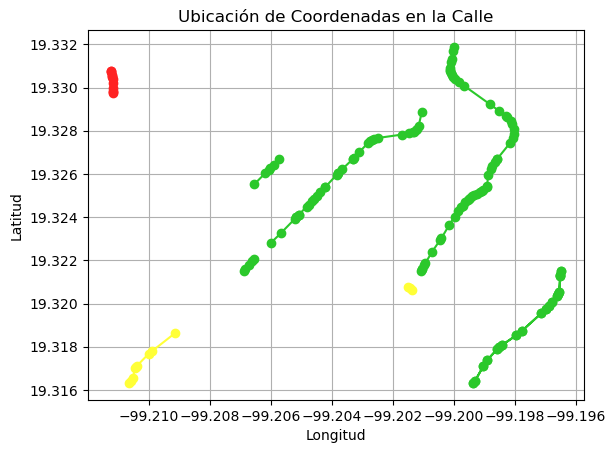

In [26]:
# Crear una nueva figura
plt.figure()

limites = [0, 0.15, 0.35, 0.75, float('inf')]
colores = ['#777777', '#FF2323', '#FFFF37', '#2BC82B']

for i in range(len(all_points)):
    latitudes, longitudes = zip(*all_points[i][0]["coordinates"])
    velocidades = all_points[i][0]["properties"][0]["traffic_level"]
    # Mapear las velocidades a los índices de colores
    indices_colores = np.digitize(velocidades, bins=limites, right=True)
    # Graficar las coordenadas en la misma figura
    plt.plot(longitudes, latitudes, color=colores[indices_colores-1], marker='o', linestyle='-')


# Personalizar la apariencia del gráfico
plt.title('Ubicación de Coordenadas en la Calle')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()

In [47]:
"""
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

columnas = ['type', 'properties', 'coordinates']
gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in all_points[0][0]["coordinates"]])

for i in range(1,len(all_points)):
    # Crear GeoDataFrame a partir de las coordenadas
    gdf1 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in all_points[i][0]["coordinates"]])

    # Concatenar los GeoDataFrames utilizando pd.concat
    gdf = pd.concat([gdf, gdf1], ignore_index=True)

# Guardar el GeoDataFrame como un archivo GeoJSON
ruta_geojson = 'conjuntos_coordenadas.geojson'
gdf.to_file(ruta_geojson, driver='GeoJSON')

print(f'Archivo GeoJSON creado en: {ruta_geojson}')
"""

Archivo GeoJSON creado en: conjuntos_coordenadas.geojson


In [60]:
"""
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString

columnas = ['type', 'properties', 'coordinates']
data = {'geometry': [all_points[0][0]["coordinates"]], 'valor_sensor': [all_points[0][0]["properties"][0]["traffic_level"]]}
gdf = gpd.GeoDataFrame(data)

for i in range(1,len(all_points)):
    # Crear GeoDataFrame a partir de las coordenadas
    data = {'geometry': [all_points[i][0]["coordinates"]], 'valor_sensor': [all_points[i][0]["properties"][0]["traffic_level"]]}
    gdf1 = gpd.GeoDataFrame(data)

    # Concatenar los GeoDataFrames utilizando pd.concat
    gdf = pd.concat([gdf, gdf1], ignore_index=True)

# Guardar el GeoDataFrame como un archivo GeoJSON
ruta_geojson = 'conjuntos_coordenadas.geojson'
print(type(gdf))
gdf.to_file(ruta_geojson, driver='GeoJSON')
print(f'Archivo GeoJSON creado en: {ruta_geojson}')
"""

'\nimport geopandas as gpd\nimport pandas as pd\nfrom shapely.geometry import LineString\n\ncolumnas = [\'type\', \'properties\', \'coordinates\']\ndata = {\'geometry\': [all_points[0][0]["coordinates"]], \'valor_sensor\': [all_points[0][0]["properties"][0]["traffic_level"]]}\ngdf = gpd.GeoDataFrame(data)\n\nfor i in range(1,len(all_points)):\n    # Crear GeoDataFrame a partir de las coordenadas\n    data = {\'geometry\': [all_points[i][0]["coordinates"]], \'valor_sensor\': [all_points[i][0]["properties"][0]["traffic_level"]]}\n    gdf1 = gpd.GeoDataFrame(data)\n\n    # Concatenar los GeoDataFrames utilizando pd.concat\n    gdf = pd.concat([gdf, gdf1], ignore_index=True)\n\n# Guardar el GeoDataFrame como un archivo GeoJSON\nruta_geojson = \'conjuntos_coordenadas.geojson\'\nprint(type(gdf))\ngdf.to_file(ruta_geojson, driver=\'GeoJSON\')\nprint(f\'Archivo GeoJSON creado en: {ruta_geojson}\')\n'

In [59]:
all_points[0]
#i=0
#print(all_points[i][0]["coordinates"])
#print(all_points[i][0]["properties"][0]["traffic_level"])

[{'type': 'LINESTRING',
  'properties': [{'traffic_level': 1.0}, {'traffic_road_coverage': 'full'}],
  'coordinates': [(19.325524613420782, -99.20654296875),
   (19.326036205570087, -99.20618623495102),
   (19.326195662863377, -99.20607894659042),
   (19.32627887172872, -99.2060212790966),
   (19.326433266885715, -99.20590996742249),
   (19.32669491605546, -99.20573126524687)]}]

In [75]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

values = []
lines = []
coverages = []
fechas = []
horas = []
for i in range(0,len(all_points)):
    values.append(all_points[i][0]["properties"][0]["traffic_level"])
    lines.append(LineString(all_points[i][0]["coordinates"]))
    coverages.append(all_points[i][0]["properties"][1]['traffic_road_coverage'])
    fechas.append(all_points[i][0]["date"])
    horas.append(all_points[i][0]["time"])

# Crear un DataFrame de ejemplo con coordenadas y valores
data = {'traffic_level': values,
        "roadCovrag": coverages,
        "date": fechas,
        "time": horas,
        'Coordinate': lines}

df = pd.DataFrame(data)

# Convertir DataFrame a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='Coordinate')

ruta_geojson = 'conjuntos_coordenadas.geojson'
# Guardar el GeoDataFrame en un archivo GeoJSON o Shapefile
#gdf.to_file(ruta_geojson, driver='GeoJSON')

In [76]:
gdf

,traffic_level,roadCovrag,date,time,Coordinate
0,1.000,full,20-02-2024,18:50:21,"LINESTRING (19.326 -99.207, 19.326 -99.206, 19..."
1,1.000,full,20-02-2024,18:50:21,"LINESTRING (19.326 -99.204, 19.326 -99.204, 19..."
2,1.000,full,20-02-2024,18:50:21,"LINESTRING (19.327 -99.203, 19.326 -99.204, 19..."
3,0.943,full,20-02-2024,18:50:21,"LINESTRING (19.325 -99.204, 19.325 -99.204, 19..."
4,0.943,full,20-02-2024,18:50:21,"LINESTRING (19.324 -99.205, 19.324 -99.205, 19..."
...,...,...,...,...,...
5574,1.000,full,26-02-2024,17:09:59,"LINESTRING (19.477 -99.044, 19.477 -99.043, 19..."
5575,1.000,full,26-02-2024,17:09:59,"LINESTRING (19.477 -99.042, 19.477 -99.042, 19..."
5576,0.292,full,26-02-2024,17:09:59,"LINESTRING (19.468 -99.052, 19.468 -99.052, 19..."
5577,1.000,full,26-02-2024,17:09:59,"LINESTRING (19.467 -99.047, 19.467 -99.047, 19..."
